In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_image(img, shape = (15, 15), img_type = "bgr"):
    plt.rcParams["figure.figsize"] = shape
    if img_type == "bgr":
        plt.imshow(img[:,:,[2,1,0]])
    elif img_type.lower() == "gray":
        plt.imshow(img, cmap='gray')

def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [3]:
img1 = cv2.imread("../data/nevada3.jpg")

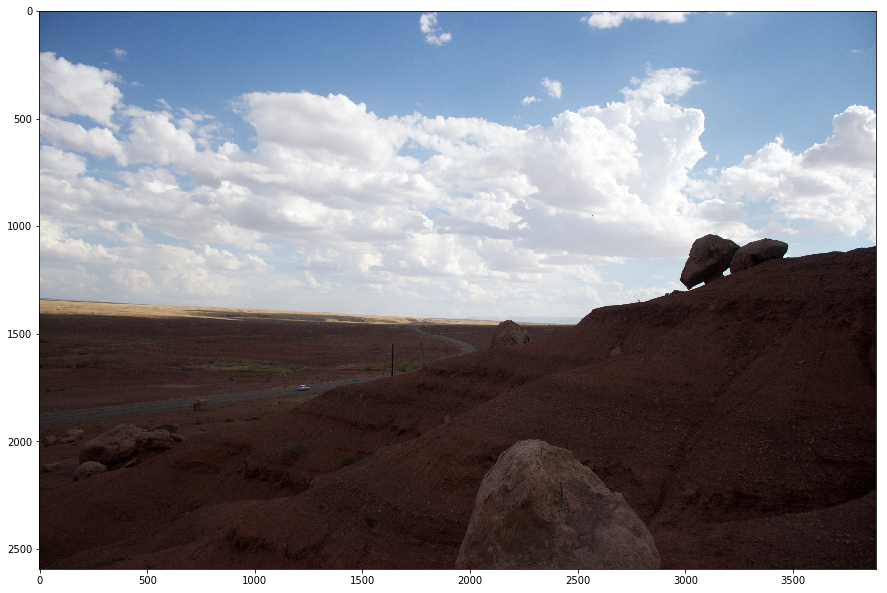

In [4]:
#https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
show_image(img1)

In [10]:
#https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
def get_sift_features(img):
    if len(img.shape) == 3:
        img = to_grayscale(img)
    sift_obj = cv2.xfeatures2d.SIFT_create()
    return sift_obj.detectAndCompute(img, None)

In [13]:
descriptors, keypoints = get_sift_features(img1)

In [15]:
keypoints

array([[  2.,   0.,   0., ...,   0.,   0.,  23.],
       [ 71., 109.,   2., ...,   0.,   0.,   0.],
       [ 15.,   1.,   0., ...,   2.,   1.,  13.],
       ...,
       [ 42.,   9.,   0., ...,   2.,   0.,   0.],
       [ 53.,  62.,  21., ..., 119.,  16.,   6.],
       [  0.,   0.,   0., ...,  34.,   3.,   1.]], dtype=float32)